# Noise plus sine wave fitting fun

Example notebook to look at how well we can fit sine wave data that is obscured by band-limited thermal noise. The setup is we amplifier the noise from a room temperature terminator by about 80dB. This gives us our 'pure' thermal noise sample.

To get our thermal noise plus signal sample we take the output of a a signal generator and insert it before the amplification (using a splitter/combiner rto mix it with our terminator). We also record a version of the clean sine wave.

Then we can look at how the frequency resolution of the measurement depends on various properties of the signal and noise. Chief amongst these are:
* The signal-to-noise ratio (a simple but misleading comparison)
* The bandwidth of the system
* The sampling rate
* The length of the measurement

## Variance of  frequency $f$
The expectation for the variance on frequency is the folllowing:
$$ \textrm{ var} \left[\hat{f} \right] = \frac{\textrm{ var} \left[\hat{\omega} \right]}{4 \pi^2} \geq   \frac{ 3 }{ \pi^2 \textrm{SNR}_P (S_R \Delta T^3 - \frac{\Delta T}{S_R}) }$$
where $f$ is frequency, $\omega$ is angular frequency ${SNR}_P=\frac{\frac{A^2}{2}}{\sigma^2}$ is the signal-to-noise ratio in terms of power (as $A$ is the sine wave amplitude, so $\frac{A^2}{2}$ is the mean square of the, and $\sigma$ is the standard deviation of the noise, $S_R$ is the sampling rate and $\Delta T$ is the observation time.

## Moving to a band limited system

$$ \textrm{ var} \left[\hat{f} \right] = \frac{\textrm{ var} \left[\hat{\omega} \right]}{4 \pi^2} \geq   \frac{ 6 \sigma^2 }{ \pi^2 A^2 (S_R \Delta T^3 - \frac{\Delta T}{S_{R}}) }$$

But we know what $\sigma^2$ is from thermal noise 
$$\sigma^2= 4 k_B T R \Delta f$$
where $T$ is system temperature, $R$ is impedance and $\Delta f$ is the sysetm band width.

So we could write this formula as:
$$ \textrm{ var} \left[\hat{f} \right] = \frac{\textrm{ var} \left[\hat{\omega} \right]}{4 \pi^2} \geq   \frac{ 12  k_B T R \Delta f }{ \pi^2 A^2 (S_R \Delta T^3 - \frac{\Delta T}{S_R}) }$$

Now in the previous study I was  keeping $\sigma^2$ constant but varying both observation time and sampling rate. Now changing the observation time (for the same sampling rate) increases the number of bins in the time and frequency domains. Whilst changing the sampling rate gives access to different frequecny ranges (up to Nyquist). So if you keep the $\sigma^2$ the same but double the sampling rate you are effectively spreading the same amount of power over a wider bandwidth (e.g in a flat model if you double the sampling rate you halve the temperature).



In [1]:
from PyScopeTools import PyScopeTools as pst
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt


# Import the curve_fit function
from scipy.optimize import curve_fit

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [2]:
# The below is the standard deviation of a pure noise sample with the sine wave generator turned off
#noiseStd=0.17231516392304297 #mV old setup with coupler
noiseStd=0.166 #mV new setup with splitter

def getDataSet(freqInMhz,ampInmV,tag):
    noisePlusSineList,timeList=pst.getScopeWaveforms("/Users/rjn/qtnm/data/noisePlusSine/npSine_"+str(freqInMhz)+"MHz_"+str(ampInmV)+"mV"+tag+".ch1.traces",True)
    justSineList,_=pst.getScopeWaveforms("/Users/rjn/qtnm/data/noisePlusSine/npSine_"+str(freqInMhz)+"MHz_"+str(ampInmV)+"mV"+tag+".ch3.traces",True)
    dt=timeList[1]-timeList[0]
    fs=1./dt
    return noisePlusSineList,justSineList,timeList,dt,fs



def zeroMeanWaveform(waveList):
   return waveList- np.mean(waveList,axis=1)[:,None]  #Need the [:,None] to expand 1D array to 2D array


def getSine(t,w,A,phi):
    """Function to return a simple sine 

    Args:
        t: The array of times
        w: The angular frequency
        A: The amplitude
        phi: The phase at t=0
 
     Returns:
        The sine values as an array

    """
    return A*np.sin((w*t)+phi)

def doSineWaveFit(waveList,guessFreq):
    numWaveforms=waveList.shape[0]
    guessOmega=guessFreq*2*math.pi
    guessAmp=np.max(waveList[0])
    guessPhase=0

    omegas=np.zeros(numWaveforms)
    freqs=np.zeros(numWaveforms)
    amps=np.zeros(numWaveforms)
    phases=np.zeros(numWaveforms)
    failCount=0

    for i in range(numWaveforms):
        try:
            parameters, covariance = curve_fit(getSine, timeList, waveList[i],p0=[guessOmega,guessAmp,guessPhase])
        except:
            print("Failure ",failCount," to fit",i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        
        omegas[i]=parameters[0]
        freqs[i]=parameters[0]/(2*math.pi)
        amps[i]=parameters[1]
        phases[i]=parameters[2]
        if i <2 :
            print(i,len(waveList[i]),freqs[i])
    return omegas,freqs,amps,phases
  



In [3]:
#freqList=[100,150,200,250,300,350,400,450,500]
#thisAmp=300#mV

jsStdList=[]
npsStdList=[]

#ampList=[50,100,150,200,250,300,350,400,450,500]
ampList=[50,100,150,200,300,500]
thisFreq=300

npsFitAmpMeanList=[]
npsFitAmpStdList=[]

def trimAndDownsample(array,start,stop,step):
    if array.ndim==2:
        return array[:,start:stop:step]
    else:
        return array[start:stop:step]


    
    
for thisAmp in ampList:
#for thisFreq in freqList:
    print("Starting",thisFreq,thisAmp)
    #noisePlusSineList,justSineList,timeList,dt,fs=getDataSet(thisFreq,thisAmp,"_50dBatten_highpass")
    noisePlusSineList,justSineList,timeList,dt,fs=getDataSet(thisFreq,thisAmp,"_long_nocoupler")
    
    #Now we are going to reshape our array to have fewer entries
    start=0 #Start index
    stop=100000 #Stop index
    step=1 #Step size (1 is every sample, 2 is every other etc.)
    justSineList=trimAndDownsample(justSineList,start, stop,step)
    noisePlusSineList=trimAndDownsample(noisePlusSineList,start, stop,step)
    timeList=trimAndDownsample(timeList,start, stop,step)
    N=len(timeList)
    dt=timeList[1]-timeList[0]
    fs=1/dt
    jsOmega,jsFreq,jsAmp,jsPhase=doSineWaveFit(justSineList,thisFreq)#,1.4e-4*thisAmp)
    %time npsOmega,npsFreq,npsAmp,npsPhase=doSineWaveFit(noisePlusSineList,thisFreq)#,2.4e-3*thisAmp)
    print(jsFreq[0],npsFreq[0])
    
    jsStdList.append(np.std(jsFreq))
    npsStdList.append(np.std(npsFreq))
    npsFitAmpMeanList.append(np.mean(npsAmp))
    npsFitAmpStdList.append(np.std(npsAmp))
    


Starting 300 50
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 299.9999905348792
1 100000 300.00011472543156
0 100000 300.0024297163096
1 100000 300.0006932914548


/Users/rjn/miniforge3/envs/ml-env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


CPU times: user 25 s, sys: 572 ms, total: 25.6 s
Wall time: 26.9 s
299.9999905348792 300.0024297163096
Starting 300 100
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 300.0003141848817
1 100000 300.00054639826027
0 100000 300.00267356344983
1 100000 300.0017332333008
CPU times: user 22 s, sys: 655 ms, total: 22.6 s
Wall time: 24.1 s
300.0003141848817 300.00267356344983
Starting 300 150
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 300.0004926951388
1 100000 300.0003876618239
0 100000 300.0016522433535
1 100000 300.00024918627884
CPU times: user 20.2 s, sys: 738 ms, total: 21 s
Wall time: 22.3 s
300.0004926951388 300.0016522433535
Starting 300 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 300.0003644402191
1 100000 300.00059118760356
0 100000 299.9999732811407
1 100000 300.0013276002828
CPU times: user 19.4 s, sys: 654 ms, total: 20.1 s
Wall time: 21.

Text(0.5, 1.0, 'Using 100000 points at 20000 MSa/s')

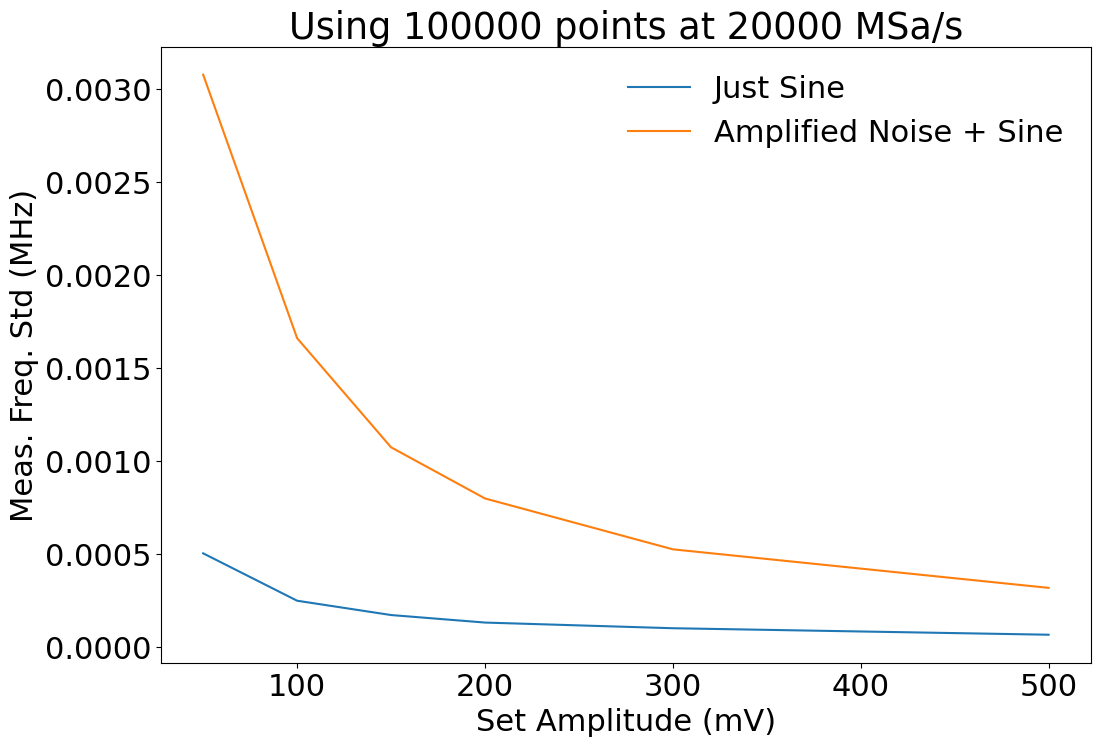

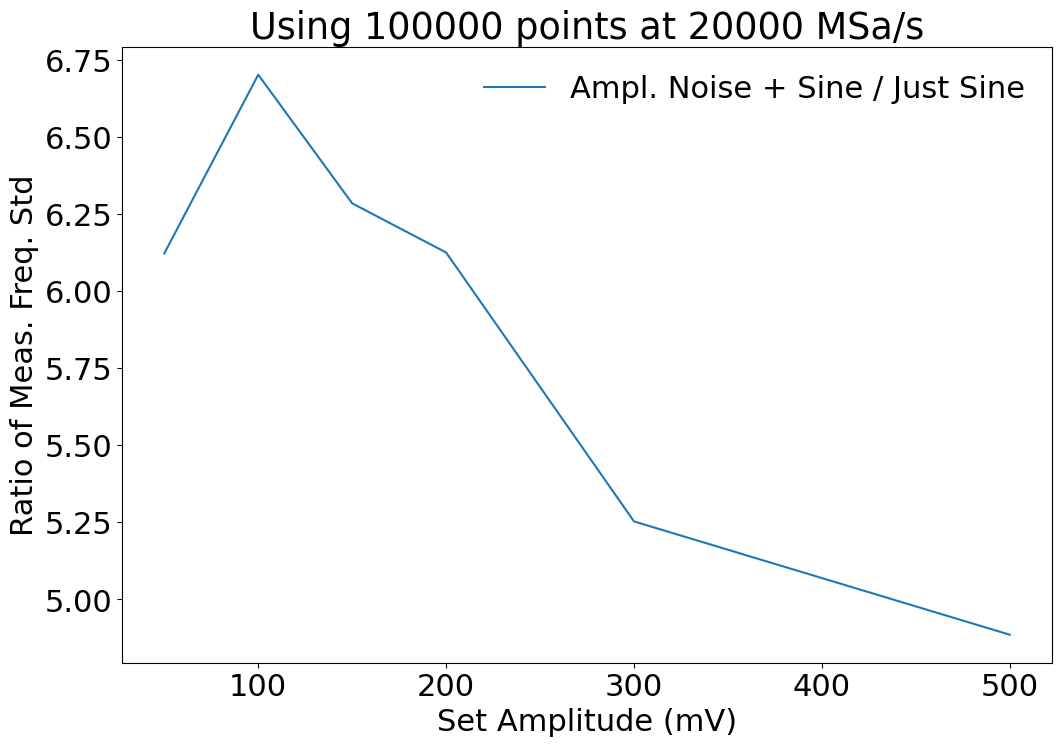

In [4]:
fig,ax = plt.subplots()
ax.plot(ampList,jsStdList,label="Just Sine")
#ax.set_xlabel("Amplitude (mV)")
ax.set_ylabel("Meas. Freq. Std (MHz)")
ax.plot(ampList,npsStdList,label="Amplified Noise + Sine")
ax.set_xlabel("Set Amplitude (mV)")
ax.set_ylabel("Meas. Freq. Std (MHz)")
ax.legend()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")

fig,ax = plt.subplots()
ax.plot(ampList,np.array(npsStdList)/np.array(jsStdList),label="Ampl. Noise + Sine / Just Sine")
#ax.set_xlabel("Amplitude (mV)")
ax.set_ylabel("Ratio of Meas. Freq. Std")
ax.set_xlabel("Set Amplitude (mV)")
ax.legend()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")

Text(0.5, 1.0, 'Using 100000 points at 20000 MSa/s')

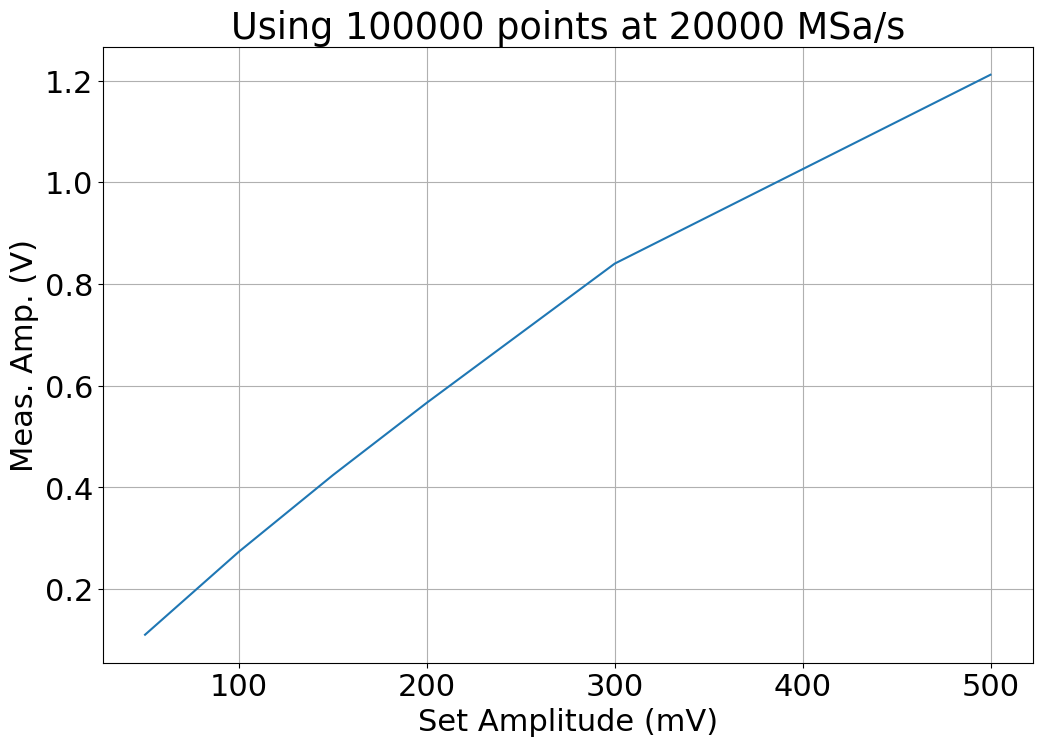

In [5]:
fig,ax = plt.subplots()
ax.plot(ampList,npsFitAmpMeanList)
ax.set_xlabel("Set Amplitude (mV)")
ax.set_ylabel("Meas. Amp. (V)")
ax.grid()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")

[ 0.22146331  1.36060507  3.26677008  5.826273   12.80864318 26.63360841]
[0.11047753600335125, 0.27383510815748524, 0.42430912372232615, 0.5666547073968868, 0.8401844695350758, 1.2115409305639537]


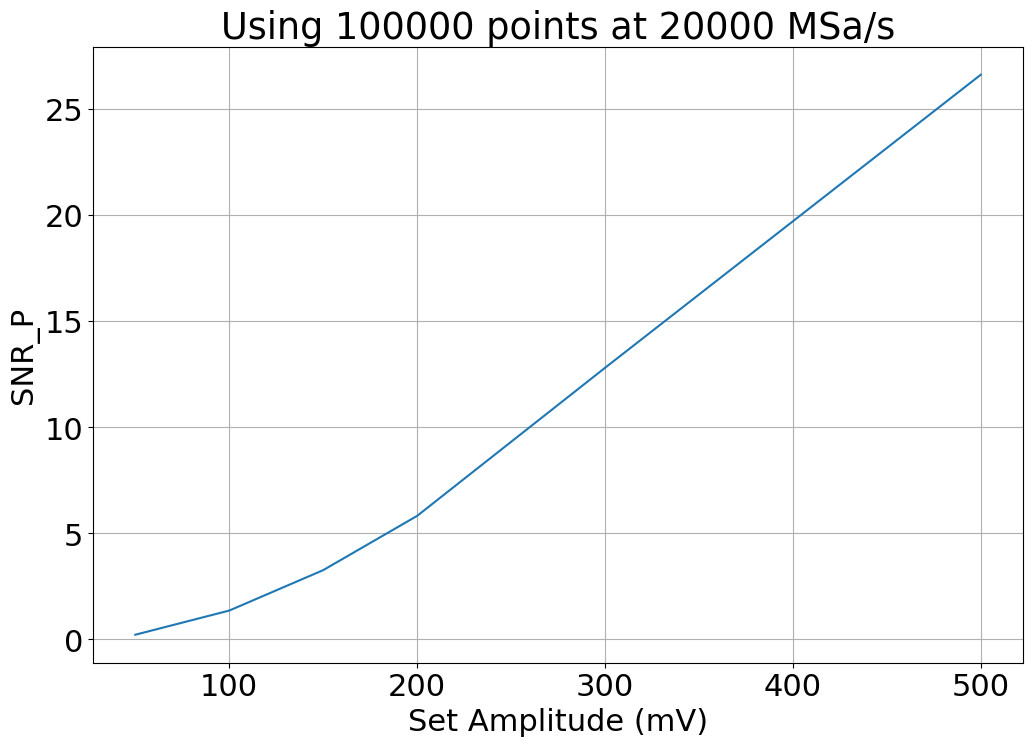

In [6]:
measSNRp=(np.array(npsFitAmpMeanList)**2)/(2*noiseStd**2)
fig,ax = plt.subplots()
ax.plot(ampList,measSNRp)
ax.set_xlabel("Set Amplitude (mV)")
ax.set_ylabel("SNR_P")
ax.grid()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")
print(measSNRp)
print(npsFitAmpMeanList)

## Variance of  frequency $f$
$$ \textrm{ var} \left[\hat{f} \right] = \frac{\textrm{ var} \left[\hat{\omega} \right]}{4 \pi^2} \geq   \frac{ 3 }{ \pi^2 \textrm{SNR}_P (R T^3 - \frac{T}{R}) }$$


19999.999732882545 4.999950066756492
19999999732.882545 4.999950066756491e-06
19.999999732882547 4999.950066756492 2.499925067494052e-06 2.4999750667675943e-16
npsFitAmpMeanList [0.11047753600335125, 0.27383510815748524, 0.42430912372232615, 0.5666547073968868, 0.8401844695350758, 1.2115409305639537]
npsFitAmpStdList [0.08860300011175086, 0.06375075019899823, 0.027269640771892752, 0.00403857455612392, 0.0037037200223136437, 0.002026836148068199]
ampList [50, 100, 150, 200, 300, 500]
formula [740.96273267 298.93806359 192.92476263 144.46140817  97.43067141
  67.56662933]
1e6*np.array(npsStdList) [3075.34433119 1659.13399686 1072.37595164  797.41231128  523.89373019
  316.70178646]
error on std deviation [6.87671336 3.70995495 2.39791751 1.78307705 1.17146785 0.70817026]


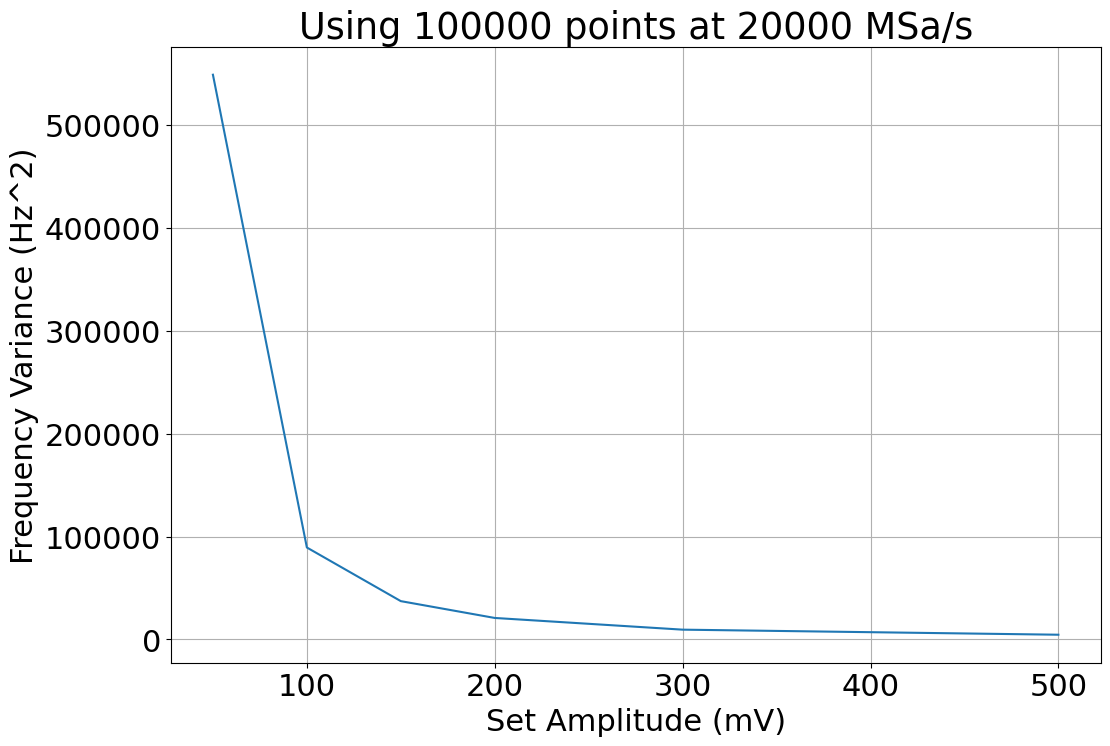

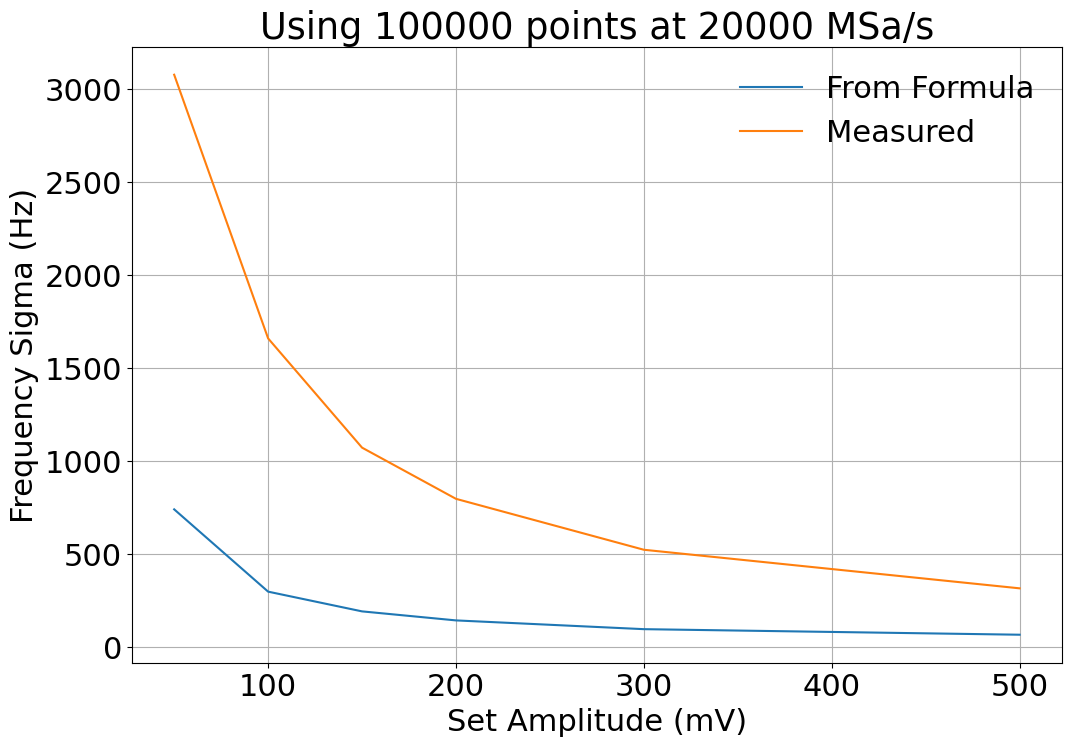

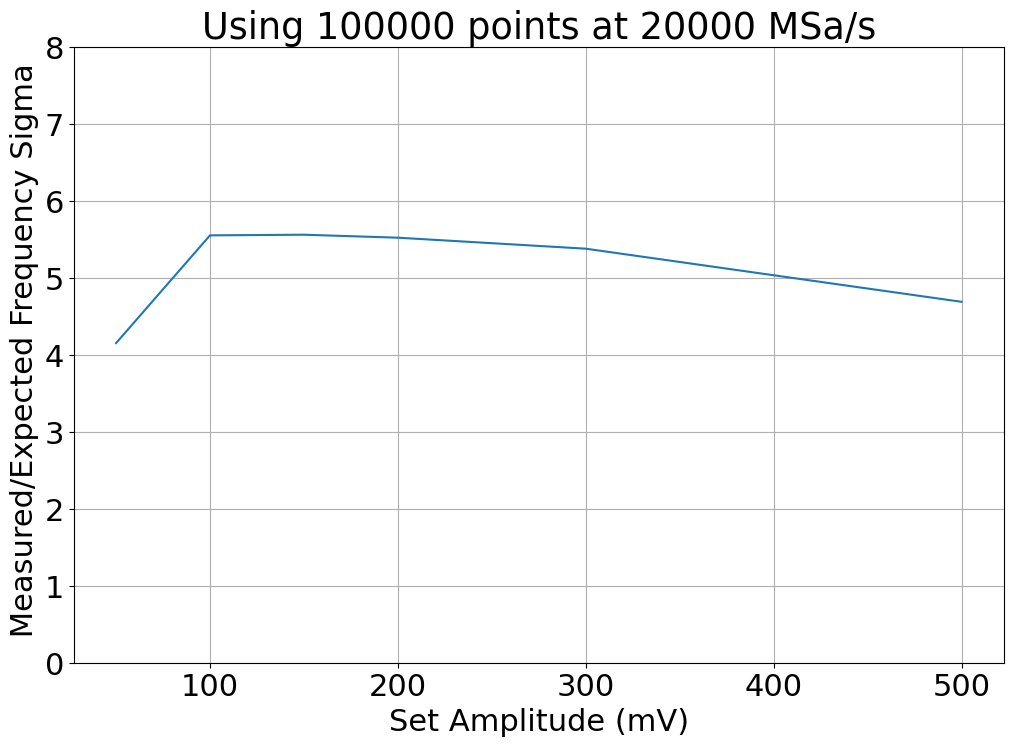

In [7]:
R=fs
T=timeList[-1]-timeList[0]

print(R,T)

#Convert to Hz,s
R=1e6*R
T=1e-6*T
print(R,T)


def getEstFreqVariance(snrp,samplingRate,observationTime):
    return 3 / (math.pi**2 *(snrp*(samplingRate*observationTime**3 - observationTime/samplingRate)))

print(R/1e9,T*1e9, R*(T**3),T/R)
fig,ax = plt.subplots()
ax.plot(ampList,getEstFreqVariance(measSNRp,R,T))
ax.set_xlabel("Set Amplitude (mV)")
ax.set_ylabel("Frequency Variance (Hz^2)")
ax.grid()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")

fig,ax = plt.subplots()
ax.plot(ampList,np.sqrt(getEstFreqVariance(measSNRp,R,T)),label="From Formula")
ax.plot(ampList,1e6*np.array(npsStdList),label="Measured")
ax.set_xlabel("Set Amplitude (mV)")
ax.set_ylabel("Frequency Sigma (Hz)")
ax.grid()
ax.legend()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")

fig,ax = plt.subplots()
ax.plot(ampList,npsStdList/(np.sqrt(getEstFreqVariance(measSNRp,R,T))/1e6))
ax.set_xlabel("Set Amplitude (mV)")
ax.set_ylabel(" Measured/Expected Frequency Sigma")
ax.set_ylim([0,8])
ax.grid()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")


print("npsFitAmpMeanList",npsFitAmpMeanList)
print("npsFitAmpStdList",npsFitAmpStdList)
print("ampList",ampList)
print("formula",np.sqrt(getEstFreqVariance(measSNRp,R,T)))
print("1e6*np.array(npsStdList)",1e6*np.array(npsStdList))
print("error on std deviation",1e6*np.array(npsStdList)/np.sqrt(2*(N-1)))


In [8]:

def trimAndDownsample(array,start,stop,step):
    if array.ndim==2:
        return array[:,start:stop:step]
    else:
        return array[start:stop:step]

stepFreqMean=[]
stepFreqStd=[]
stepAmpMean=[]
stepAmpStd=[]

stepFreqMeanJS=[]
stepFreqStdJS=[]
stepAmpMeanJS=[]
stepAmpStdJS=[]

stepArray=np.arange(1,40,4)
msaPerSecArray=np.zeros(len(stepArray))

for ind,step in enumerate(stepArray):
    print("Starting step size",step)
    nnpsFitAmpMeanList=[]
    nnpsFitAmpStdList=[]
    nnpsFitFreqMeanList=[]
    nnpsFitFreqStdList=[]
    njsFitAmpMeanList=[]
    njsFitAmpStdList=[]
    njsFitFreqMeanList=[]
    njsFitFreqStdList=[]

    
    for thisAmp in ampList:
        print("Starting",thisFreq,thisAmp)
        npsList,jsList,tList,dt,fs=getDataSet(thisFreq,thisAmp,"_long_nocoupler")
        
        #Now we are going to reshape our array to have fewer entries
        start=0 #Start index
        stop=100000 #Stop index
        nnpsList=trimAndDownsample(npsList,start,stop,step)
        njsList=trimAndDownsample(jsList,start,stop,step)
        ntList=trimAndDownsample(tList,start,stop,step)
        N=ntList.shape[0] #
        dt=ntList[1]-ntList[0]
        fs=1./dt
        msaPerSecArray[ind]=fs
        timeList=ntList
        nnpsOmega,nnpsFreq,nnpsAmp,nnpsPhase=doSineWaveFit(nnpsList,thisFreq)#,2.4e-3*thisAmp)
        nnpsFitAmpMeanList.append(np.mean(nnpsAmp))
        nnpsFitAmpStdList.append(np.std(nnpsAmp))
        nnpsFitFreqMeanList.append(np.mean(nnpsFreq))
        nnpsFitFreqStdList.append(np.std(nnpsFreq))
        njsOmega,njsFreq,njsAmp,njsPhase=doSineWaveFit(njsList,thisFreq)#,2.4e-3*thisAmp)
        njsFitAmpMeanList.append(np.mean(njsAmp))
        njsFitAmpStdList.append(np.std(njsAmp))
        njsFitFreqMeanList.append(np.mean(njsFreq))
        njsFitFreqStdList.append(np.std(njsFreq))
        print(np.shape(timeList))
        print("Freq std",np.std(nnpsFreq))
    stepFreqMean.append(np.array(nnpsFitFreqMeanList))
    stepFreqStd.append(np.array(nnpsFitFreqStdList))
    stepAmpMean.append(np.array(nnpsFitAmpMeanList))
    stepAmpStd.append(np.array(nnpsFitAmpStdList))
    stepFreqMeanJS.append(np.array(njsFitFreqMeanList))
    stepFreqStdJS.append(np.array(njsFitFreqStdList))
    stepAmpMeanJS.append(np.array(njsFitAmpMeanList))
    stepAmpStdJS.append(np.array(njsFitAmpStdList))
    

Starting step size 1
Starting 300 50
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 300.0024297163096
1 100000 300.0006932914548
0 100000 299.9999905348792
1 100000 300.00011472543156
(100000,)
Freq std 0.0030753443311899117
Starting 300 100
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 300.00267356344983
1 100000 300.0017332333008
0 100000 300.0003141848817
1 100000 300.00054639826027
(100000,)
Freq std 0.001659133996859976
Starting 300 150
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 300.0016522433535
1 100000 300.00024918627884
0 100000 300.0004926951388
1 100000 300.0003876618239
(100000,)
Freq std 0.001072375951642966
Starting 300 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 299.9999732811407
1 100000 300.0013276002828
0 100000 300.0003644402191
1 100000 300.00059118760356
(100000,)
Freq std 0.00079

In [9]:
print(np.shape(stepFreqStd))
print(stepFreqStd[0])
print(stepFreqStd[1])

(10, 6)
[0.00307534 0.00165913 0.00107238 0.00079741 0.00052389 0.0003167 ]
[0.00307939 0.00166333 0.00107368 0.00079775 0.00052457 0.00031851]


Text(0, 0.5, 'Frequency Sigma (MHz)')

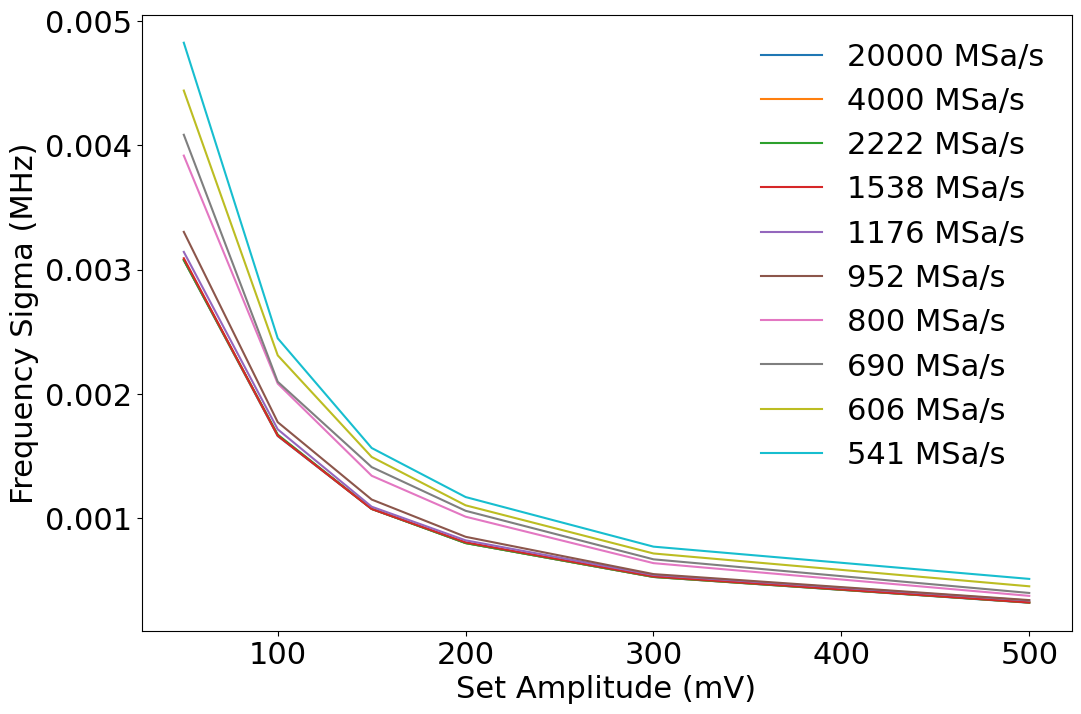

In [10]:
fig,ax = plt.subplots()
for i in range(len(msaPerSecArray)):
    ax.plot(ampList,stepFreqStd[i],label=str(int(np.round(msaPerSecArray[i],0)))+" MSa/s")
#ax.plot(ampList,np.sqrt(getEstFreqVariance(measSNRp,1000e6,T))/1e6,label="From Formula")
ax.legend()
ax.set_xlabel("Set Amplitude (mV)")
ax.set_ylabel("Frequency Sigma (MHz)")


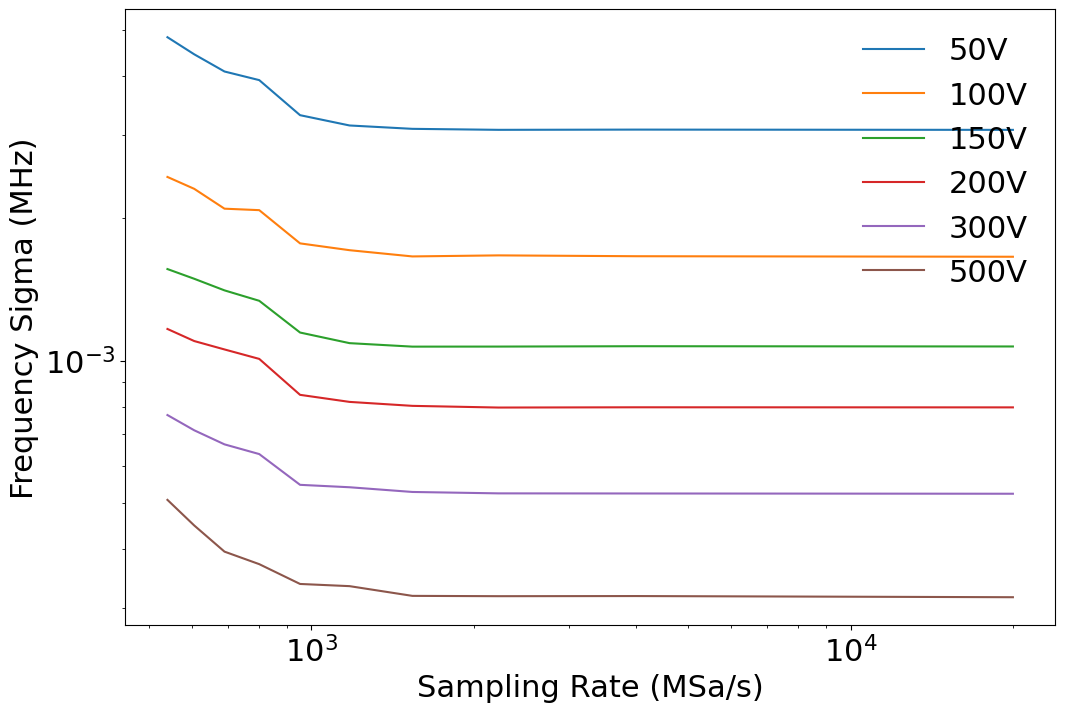

In [11]:
fig,ax = plt.subplots()
for i in range(len(ampList)):
    ax.plot(msaPerSecArray,np.array(stepFreqStd).T[i],label=str(int(np.round(ampList[i],0)))+"V")
ax.legend()
ax.set_xlabel("Sampling Rate (MSa/s)")
ax.set_ylabel("Frequency Sigma (MHz)")
ax.set_yscale('log')
ax.set_xscale('log')